# **Brain Segmentation using QuickNAT**

This notebook will introduce you to an end-to-end working in MONAI using a standard PyTorch loop. We will train QuickNAT, which is a Fully Convolutional Neural Network for quick and accurate brain segmentation. The architecture proposed by Roy, Abhijit Guha and his team is available in GitHub on Pytorch: https://github.com/ai-med/quickNAT_pytorch.

QuickNAT consists of three 2D F-CNNs operating on coronal, axial and sagittal views followed by a view aggregation step to infer the final segmentation. Each F-CNN has the same architecture and is inspired by the traditional encoder/decoder based U-Net architecture with skip connections and enhanced with unpooling layers in the decoder stages. 

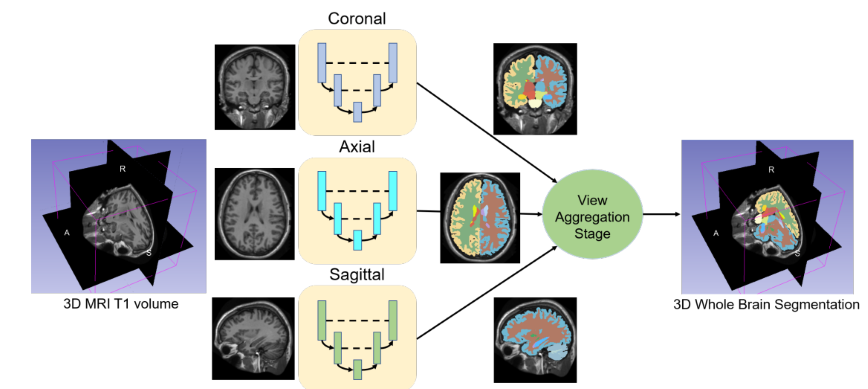



---




# End-to-End Training Workflow

To help guide you through training QuickNAT using MONAI, this guide will cover four key phases:

1. Setting up our Dataset and exploring the data
2. Preparing Datasets and Transforms
3. Define QuickNAT Network and create a PyTorch training loop
4. Evaluate the model and understand the results

**Setup environment**

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import torchio" || pip install -q torchio
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 1.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'torchio'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.5 MB/s eta 0:00:00


In [2]:
from monai.config import print_config

In [3]:
from monai.utils import set_determinism, first
from monai.data import Dataset, DataLoader, partition_dataset
from monai.data.image_reader import PILReader
from monai.transforms import Transform, Compose, LoadImaged, NormalizeIntensityd, ToTensord, Rotate90d
from monai.losses import DiceCELoss
from monai.apps import download_and_extract
from monai.metrics import DiceMetric

**Setup imports**

In [4]:
import os
from glob import glob
import tempfile
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchio
import nibabel as nib
import matplotlib.pyplot as plt
import shutil
import time
import random 
import gc
from PIL import Image
import natsort
from enum import Enum

In [5]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

print_config()

MONAI version: 1.2.dev2316
Numpy version: 1.22.4
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5e7585af9194bc2a038070e7deee13fef773c7c7
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.2
gdown version: 4.6.6
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-re

# 1. Setting up our Dataset and exploring the data

**1.1 Setup data directory**

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable. This allows you to save results and reuse downloads. If not specified, a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpx3d956bz


**1.2 Download OASIS Dataset**

OASIS is a project aimed at making neuroimaging data sets of the brain freely available to the scientific community. We will download a subset of OASIS-1 data which contains MRI T1 scans from 43 subjects with annotations obtained from FreeSurfer and extract it into our temporary MONAI Data Directory. 

Data were provided by OASIS-1: Cross-Sectional: Principal Investigators: D. Marcus, R, Buckner, J, Csernansky J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382.

In [7]:
resource = "https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc1.tar.gz"
md5 = "c83e216ef8654a7cc9e2a30a4cdbe0cc"

compressed_file = os.path.join(root_dir, "oasis_cross-sectional_disc1.tar.gz")
data_dir = os.path.join(root_dir, "Oasis_Data")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, data_dir, md5)

oasis_cross-sectional_disc1.tar.gz: 1.29GB [00:13, 104MB/s]                             

2023-04-20 08:43:16,376 - INFO - Downloaded: /tmp/tmpx3d956bz/oasis_cross-sectional_disc1.tar.gz


2023-04-20 08:43:21,269 - INFO - Verified 'oasis_cross-sectional_disc1.tar.gz', md5: c83e216ef8654a7cc9e2a30a4cdbe0cc.
2023-04-20 08:43:21,278 - INFO - Writing into directory: /tmp/tmpx3d956bz/Oasis_Data.


**1.3 Set deterministic training for reproducibility**

In [8]:
set_determinism(seed=0)

**1.4 Visualize image and labels filename from the dataset folder**

1. Convert .img file to .nii and save it to new folder 

The first step is to convert the files from .img format to .nii as our model works with NIfTI format. We are going to create two new folders in our directory. Oasis_Data_Processed includes a processed MRI T1 scan of each patient and Oasis_Labels_Processed includes the corresponding labels obtained with FreeSurfer. 

In [9]:
new_path_data= root_dir + '/Oasis_Data_Processed/'
if not os.path.exists(new_path_data):
  os.makedirs(new_path_data)

In [10]:
for i in [x for x in range(1, 43) if x != 8 and x != 24 and x != 36]:
  if i < 7 or i == 9:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_000' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc.img'
  elif i == 7: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_000' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc.img'
  elif i==15 or i==16 or i==20 or i==24 or i==26 or i==34 or i==38 or i==39:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_00' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc.img'
  else: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_00' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc.img'
  img = nib.load(filename)
  nib.save(img, filename.replace('.img', '.nii'))
  i = i+1  

In [11]:
for i in [x for x in range(1, 43) if x != 8 and x != 24 and x != 36]:
  if i < 7 or i == 9:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_000' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc.nii'
  elif i == 7: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_000' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc.nii'
  elif i==15 or i==16 or i==20 or i==24 or i==26 or i==34 or i==38 or i==39:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_00' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc.nii'
  else: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/PROCESSED/MPRAGE/T88_111/OAS1_00' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc.nii'
  shutil.copy(filename, new_path_data)
  i = i+1 

In [12]:
new_path_labels= root_dir + '/Oasis_Labels_Processed/'
if not os.path.exists(new_path_labels):
  os.makedirs(new_path_labels)

In [13]:
for i in [x for x in range(1, 43) if x != 8 and x != 24 and x != 36]:
  if i < 7 or i == 9:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/FSL_SEG/OAS1_000' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img'
  elif i == 7: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/FSL_SEG/OAS1_000' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg.img'
  elif i==15 or i==16 or i==20 or i==24 or i==26 or i==34 or i==38 or i==39:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/FSL_SEG/OAS1_00' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg.img'
  else: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/FSL_SEG/OAS1_00' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img'
  img = nib.load(filename)
  nib.save(img, filename.replace('.img', '.nii'))
  i = i+1  

In [14]:
for i in [x for x in range(1, 43) if x != 8 and x != 24 and x != 36]:
  if i < 7 or i == 9:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/FSL_SEG/OAS1_000' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.nii'
  elif i == 7: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_000'+ str(i) + '_MR1/FSL_SEG/OAS1_000' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg.nii'
  elif i==15 or i==16 or i==20 or i==24 or i==26 or i==34 or i==38 or i==39:
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/FSL_SEG/OAS1_00' + str(i) + '_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg.nii'
  else: 
    filename = root_dir + '/Oasis_Data/disc1/OAS1_00'+ str(i) + '_MR1/FSL_SEG/OAS1_00' + str(i) + '_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.nii'
  shutil.copy(filename, new_path_labels)
  i = i+1 

2. Read the image and labels filenames

In [15]:
image_files = sorted(glob(os.path.join(root_dir + '/Oasis_Data_Processed', '*.nii')))
label_files = sorted(glob(os.path.join(root_dir + '/Oasis_Labels_Processed', '*.nii')))
files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(image_files, label_files)]

3. Visualize image and labels filenames

To visualize an image with its corresponding labels we will use TorchIO, which is a Python library for loading, preprocessing, augmentation and sampling for multidimensional medical images in Deep Learning. 

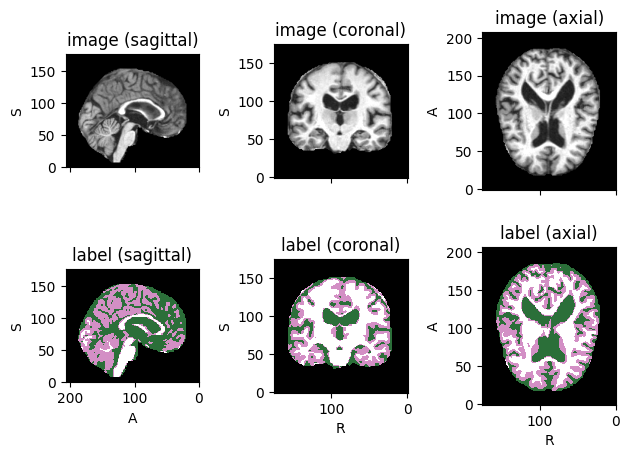

In [16]:
image_filename = root_dir + '/Oasis_Data_Processed/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.nii'
label_filename = root_dir + '/Oasis_Labels_Processed/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.nii'
subject = torchio.Subject(image=torchio.ScalarImage(image_filename), label=torchio.LabelMap(label_filename))
subject.plot()

# 2. Preparing Datasets and Transforms

**2.1 Train, Validation and Test Split**

We want to split our data into training, validation and testing sets. We will use a ratio of 80:10:10 for those sets. 

In [17]:
train_inds, val_inds, test_inds = partition_dataset(data = np.arange(len(files)), ratios = [8, 1, 1], shuffle = True)

train = [files[i] for i in sorted(train_inds)]
val = [files[i] for i in sorted(val_inds)]
test = [files[i] for i in sorted(test_inds)]

print(f"Training count: {len(train)}, Validation count: {len(val)}, Test count: {len(test)}")


Training count: 31, Validation count: 4, Test count: 4


In [18]:
train_x = []
train_y = []
for i in range(0, 31):
  train_x.append(train[i]['image'])
  train_y.append(train[i]['label'])

val_x = []
val_y = []
for i in range(0, 4):
  val_x.append(train[i]['image'])
  val_y.append(train[i]['label'])

test_x = []
test_y = []
for i in range(0, 4):
  test_x.append(train[i]['image'])
  test_y.append(train[i]['label'])

**2.2 Create Train, Validation and Test folders in the directory**

In [19]:
os.makedirs(os.path.join(root_dir, "TrainData"))
train_data_path = root_dir + '/TrainData'
for i in range(len(train_x)):
  shutil.copy(train_x[i], train_data_path)

os.makedirs(os.path.join(root_dir, "TrainLabels"))
train_labels_path = root_dir + '/TrainLabels'
for i in range(len(train_y)):
  shutil.copy(train_y[i], train_labels_path)

os.makedirs(os.path.join(root_dir, "ValData"))
val_data_path = root_dir + '/ValData'
for i in range(len(val_x)):
  shutil.copy(val_x[i], val_data_path)

os.makedirs(os.path.join(root_dir, "ValLabels"))
val_labels_path = root_dir + '/ValLabels'
for i in range(len(val_y)):
  shutil.copy(val_y[i], val_labels_path)

os.makedirs(os.path.join(root_dir, "TestData"))
test_data_path = root_dir + '/TestData'
for i in range(len(test_x)):
  shutil.copy(test_x[i], test_data_path)

os.makedirs(os.path.join(root_dir, "TestLabels"))
test_labels_path = root_dir + '/TestLabels'
for i in range(len(test_y)):
  shutil.copy(test_y[i], test_labels_path)

**2.3 Save sagital, coronal and axial slices**

Training

In [20]:
# Save sagittal slices for training images
dir = root_dir + '/TrainData'
os.makedirs(os.path.join(dir, "Sagittal"))
path = root_dir + '/TrainData/Sagittal/'

for file in sorted(glob(os.path.join(root_dir + '/TrainData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, i]
    array = slice.numpy()
    data_dir = root_dir + '/TrainData/Sagittal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [21]:
# Save sagittal slices for training labels
dir = root_dir + '/TrainLabels'
os.makedirs(os.path.join(dir, "Sagittal"))
path = root_dir + '/TrainLabels/Sagittal/'

for file in sorted(glob(os.path.join(root_dir + '/TrainLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, i]
    array = slice.numpy()
    data_dir = root_dir + '/TrainLabels/Sagittal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

In [22]:
# Save coronal slices for training images
dir = root_dir + '/TrainData'
os.makedirs(os.path.join(dir, "Coronal"))
path = root_dir + '/TrainData/Coronal/'

for file in sorted(glob(os.path.join(root_dir + '/TrainData', '*.nii'))):
  image=torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 208):
    slice = data[0, :, i]
    array = slice.numpy()
    data_dir = root_dir + '/TrainData/Coronal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [23]:
# Save coronal slices for training labels
dir = root_dir + '/TrainLabels'
os.makedirs(os.path.join(dir, "Coronal"))
path = root_dir + '/TrainLabels/Coronal/'

for file in sorted(glob(os.path.join(root_dir + '/TrainLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 208):
    slice = data[0, :, i]
    array = slice.numpy()
    data_dir = root_dir + '/TrainLabels/Coronal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

In [24]:
# Save axial slices for training images
dir = root_dir + '/TrainData'
os.makedirs(os.path.join(dir, "Axial"))
path = root_dir + '/TrainData/Axial/'

for file in sorted(glob(os.path.join(root_dir + '/TrainData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, ..., i]
    array = slice.numpy()
    data_dir = root_dir + '/TrainData/Axial/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [25]:
# Save axial slices for training labels
dir = root_dir + '/TrainLabels'
os.makedirs(os.path.join(dir, "Axial"))
path = root_dir + '/TrainLabels/Axial/'

for file in sorted(glob(os.path.join(root_dir + '/TrainLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, ..., i]
    array = slice.numpy()
    data_dir = root_dir + '/TrainLabels/Axial/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

Validation

In [26]:
# Save sagital slices for validation images
dir = root_dir + '/ValData'
os.makedirs(os.path.join(dir, "Sagittal"))
path = root_dir + '/ValData/Sagittal/'

for file in sorted(glob(os.path.join(root_dir + '/ValData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, i]
    array = slice.numpy()
    data_dir = root_dir + '/ValData/Sagittal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [27]:
# Save sagittal slices for validation labels
dir = root_dir + '/ValLabels'
os.makedirs(os.path.join(dir, "Sagittal"))
path = root_dir + '/ValLabels/Sagittal/'

for file in sorted(glob(os.path.join(root_dir + '/ValLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, i]
    array = slice.numpy()
    data_dir = root_dir + '/ValLabels/Sagittal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

In [28]:
# Save coronal slices for validation images
dir = root_dir + '/ValData'
os.makedirs(os.path.join(dir, "Coronal"))
path = root_dir + '/ValData/Coronal/'

for file in sorted(glob(os.path.join(root_dir + '/ValData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 208):
    slice = data[0, :, i]
    array = slice.numpy()
    data_dir = root_dir + '/ValData/Coronal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [29]:
# Save coronal slices for validation labels
dir = root_dir + '/ValLabels'
os.makedirs(os.path.join(dir, "Coronal"))
path = root_dir + '/ValLabels/Coronal/'

for file in sorted(glob(os.path.join(root_dir + '/ValLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 208):
    slice = data[0, :, i]
    array = slice.numpy()
    data_dir = root_dir + '/ValLabels/Coronal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

In [30]:
# Save axial slices for validation images
dir = root_dir + '/ValData'
os.makedirs(os.path.join(dir, "Axial"))
path = root_dir + '/ValData/Axial/'

for file in sorted(glob(os.path.join(root_dir + '/ValData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, ..., i]
    array = slice.numpy()
    data_dir = root_dir + '/ValData/Axial/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [31]:
# Save axial slices for validation labels
dir = root_dir + '/ValLabels'
os.makedirs(os.path.join(dir, "Axial"))
path = root_dir + '/ValLabels/Axial/'

for file in sorted(glob(os.path.join(root_dir + '/ValLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, ..., i]
    array = slice.numpy()
    data_dir = root_dir + '/ValLabels/Axial/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

Test

In [32]:
# Save sagital slices for test images
dir = root_dir + '/TestData'
os.makedirs(os.path.join(dir, "Sagittal"))
path = root_dir + '/TestData/Sagittal/'

for file in sorted(glob(os.path.join(root_dir + '/TestData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, i]
    array = slice.numpy()
    data_dir = root_dir + '/TestData/Sagittal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [33]:
# Save sagittal slices for Test Labels
dir = root_dir + '/TestLabels'
os.makedirs(os.path.join(dir, "Sagittal"))
path = root_dir + '/TestLabels/Sagittal/'

for file in sorted(glob(os.path.join(root_dir + '/TestLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, i]
    array = slice.numpy()
    data_dir = root_dir + '/TestLabels/Sagittal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

In [34]:
# Save coronal slices for test images
dir = root_dir + '/TestData'
os.makedirs(os.path.join(dir, "Coronal"))
path = root_dir + '/TestData/Coronal/'

for file in sorted(glob(os.path.join(root_dir + '/TestData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 208):
    slice = data[0, :, i]
    array = slice.numpy()
    data_dir = root_dir + '/TestData/Coronal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [35]:
# Save coronal slices for test labels
dir = root_dir + '/TestLabels'
os.makedirs(os.path.join(dir, "Coronal"))
path = root_dir + '/TestLabels/Coronal/'

for file in sorted(glob(os.path.join(root_dir + '/TestLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 208):
    slice = data[0, :, i]
    array = slice.numpy()
    data_dir = root_dir + '/TestLabels/Coronal/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

In [36]:
# Save axial slices for test images
dir = root_dir + '/TestData'
os.makedirs(os.path.join(dir, "Axial"))
path = root_dir + '/TestData/Axial/'

for file in sorted(glob(os.path.join(root_dir + '/TestData', '*.nii'))):
  image = torchio.ScalarImage(file)
  data = image.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, ..., i]
    array = slice.numpy()
    data_dir = root_dir + '/TestData/Axial/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png', cmap = plt.cm.gray)

In [37]:
# Save axial slices for test labels
dir = root_dir + '/TestLabels'
os.makedirs(os.path.join(dir, "Axial"))
path = root_dir + '/TestLabels/Axial/'

for file in sorted(glob(os.path.join(root_dir + '/TestLabels', '*.nii'))):
  label = torchio.LabelMap(file)
  data = label.data
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)
  for i in range(0, 176):
    slice = data[0, ..., i]
    array = slice.numpy()
    data_dir = root_dir + '/TestLabels/Axial/' + filename[0] + '_slice' + str(i) + '.png'
    plt.imsave(fname = data_dir, arr = array, format = 'png')

**2.4 Define train_files and val_files dictionaries**

Sagittal Slices

In [38]:
train_images_sagittal = []
for file in sorted(glob(os.path.join(root_dir + '/TrainData/Sagittal', '*.png'))):
  train_images_sagittal.append(file)
train_images_sagittal = natsort.natsorted(train_images_sagittal)

train_labels_sagittal = []
for file in sorted(glob(os.path.join(root_dir + '/TrainLabels/Sagittal', '*.png'))):
  train_labels_sagittal.append(file)
train_labels_sagittal = natsort.natsorted(train_labels_sagittal)

val_images_sagittal = []
for file in sorted(glob(os.path.join(root_dir + '/ValData/Sagittal', '*.png'))):
  val_images_sagittal.append(file)
val_images_sagittal = natsort.natsorted(val_images_sagittal)

val_labels_sagittal = []
for file in sorted(glob(os.path.join(root_dir + '/ValLabels/Sagittal', '*.png'))):
  val_labels_sagittal.append(file)
val_labels_sagittal = natsort.natsorted(val_labels_sagittal)

In [39]:
train_files_sagittal = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images_sagittal, train_labels_sagittal)]
val_files_sagittal = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(val_images_sagittal, val_labels_sagittal)]

Coronal Slices

In [40]:
train_images_coronal = []
for file in sorted(glob(os.path.join(root_dir + '/TrainData/Coronal', '*.png'))):
  train_images_coronal.append(file)
train_images_coronal = natsort.natsorted(train_images_coronal)

train_labels_coronal = []
for file in sorted(glob(os.path.join(root_dir + '/TrainLabels/Coronal', '*.png'))):
  train_labels_coronal.append(file)
train_labels_coronal= natsort.natsorted(train_labels_coronal)

val_images_coronal = []
for file in sorted(glob(os.path.join(root_dir + '/ValData/Coronal', '*.png'))):
  val_images_coronal.append(file)
val_images_coronal = natsort.natsorted(val_images_coronal)

val_labels_coronal = []
for file in sorted(glob(os.path.join(root_dir + '/ValLabels/Coronal', '*.png'))):
  val_labels_coronal.append(file)
val_labels_coronal = natsort.natsorted(val_labels_coronal)

test_images_coronal = []
for file in sorted(glob(os.path.join(root_dir + '/TestData/Coronal', '*.png'))):
  test_images_coronal.append(file)
test_images_coronal = natsort.natsorted(test_images_coronal)

test_labels_coronal = []
for file in sorted(glob(os.path.join(root_dir + '/TestLabels/Coronal', '*.png'))):
  test_labels_coronal.append(file)
test_labels_coronal = natsort.natsorted(test_labels_coronal)

In [41]:
train_files_coronal = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images_coronal, train_labels_coronal)]
val_files_coronal = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(val_images_coronal, val_labels_coronal)]
test_files_coronal = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(test_images_coronal, test_labels_coronal)]

Axial Slices

In [42]:
train_images_axial = []
for file in sorted(glob(os.path.join(root_dir + '/TrainData/Axial', '*.png'))):
  train_images_axial.append(file)
train_images_axial= natsort.natsorted(train_images_axial)

train_labels_axial = []
for file in sorted(glob(os.path.join(root_dir + '/TrainLabels/Axial', '*.png'))):
  train_labels_axial.append(file)
train_labels_axial= natsort.natsorted(train_labels_axial)

val_images_axial = []
for file in sorted(glob(os.path.join(root_dir + '/ValData/Axial', '*.png'))):
  val_images_axial.append(file)
val_images_axial = natsort.natsorted(val_images_axial)

val_labels_axial = []
for file in sorted(glob(os.path.join(root_dir + '/ValLabels/Axial', '*.png'))):
  val_labels_axial.append(file)
val_labels_axial = natsort.natsorted(val_labels_axial)

In [43]:
train_files_axial = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images_axial, train_labels_axial)]
val_files_axial = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(val_images_axial, val_labels_axial)]

**2.5 Setup Transforms for Training and Validation**

In [44]:
train_transforms = Compose(
     [
        LoadImaged(keys = ['image', 'label'], reader=PILReader(converter=lambda image: image.convert("L")), ensure_channel_first = True),
        Rotate90d(keys = ['image', 'label'], k = 2),
        ToTensord(keys = ['image', 'label']),
        NormalizeIntensityd(keys = ['image'])
     ]
 )

val_transforms = Compose(
     [
        LoadImaged(keys = ['image', 'label'], reader=PILReader(converter=lambda image: image.convert("L")), ensure_channel_first = True),
        Rotate90d(keys = ['image', 'label'], k = 2),
        ToTensord(keys = ['image', 'label']),
        NormalizeIntensityd(keys = ['image'])
     ]
 )

test_transforms = Compose(
     [
        LoadImaged(keys = ['image', 'label'], reader=PILReader(converter=lambda image: image.convert("L")), ensure_channel_first = True),
        ToTensord(keys = ['image', 'label']),
        NormalizeIntensityd(keys = ['image'])
     ]
 )

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


**2.6 Check transforms in DataLoader**

Image shape: torch.Size([1, 176, 176]), Label shape: torch.Size([1, 176, 176])


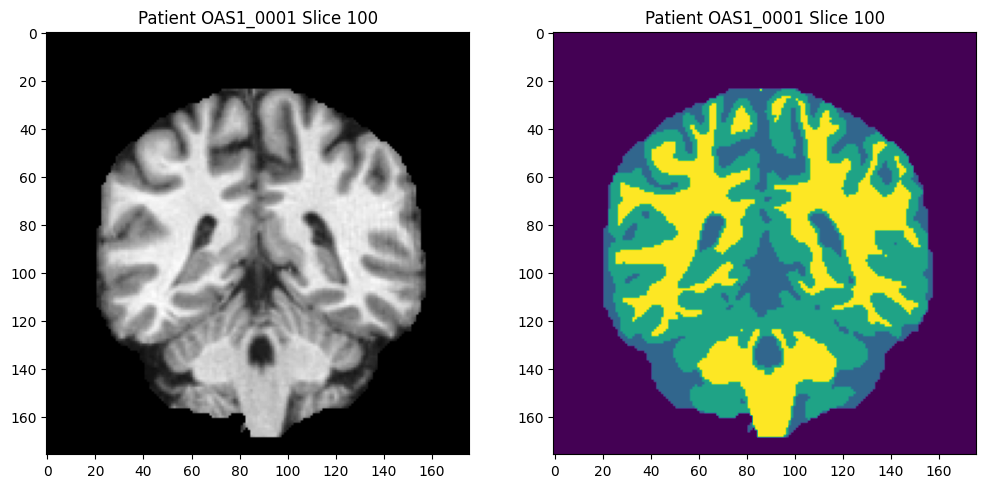

In [45]:
check_ds = Dataset(train_files_coronal, transform = train_transforms)
check_data = check_ds[80]
image_coronal, label_coronal = (check_data["image"], check_data["label"])
print(f"Image shape: {image_coronal.shape}, Label shape: {label_coronal.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Patient OAS1_0001 Slice 100")
plt.imshow(image_coronal[0, :, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Patient OAS1_0001 Slice 100")
plt.imshow(label_coronal[0, :, :])
plt.show()

MaskColorMap maps the corresponding pixel values to Label 0: Background, Label 1: LeftCerebralExterior, Label 2: LeftWhiteMatter, Label 3: LeftCerebralCortex. 

In [46]:
class MaskColorMap(Enum):
    Background = (30)
    LeftCerebralExterior = (91)
    LeftWhiteMatter = (137)
    LeftCerebralCortex = (215)

**2.7 Define Dataset and DataLoader for Training and Validation**

Sagital

In [47]:
train_dataset_sagittal = Dataset(data = train_files_sagittal, transform = train_transforms)
train_loader_sagittal = DataLoader(train_dataset_sagittal, batch_size = 1, shuffle = True, num_workers = 0)
val_dataset_sagittal = Dataset(data = val_files_sagittal, transform = val_transforms)
val_loader_sagittal = DataLoader(val_dataset_sagittal, batch_size = 1, num_workers = 0)

Coronal

In [48]:
train_dataset_coronal = Dataset(data=train_files_coronal, transform = train_transforms)
train_loader_coronal = DataLoader(train_dataset_coronal, batch_size = 1, shuffle = True)

val_dataset_coronal = Dataset(data = val_files_coronal, transform = val_transforms)
val_loader_coronal = DataLoader(val_dataset_coronal, batch_size = 1, shuffle = False)

test_dataset_coronal = Dataset(data = test_files_coronal, transform = test_transforms)
test_loader_coronal = DataLoader(test_dataset_coronal, batch_size = 1, shuffle = False)

# We will use a subset of the dataset
subset_train = list(range(90, len(train_dataset_coronal), 120))
train_dataset_coronal_subset = torch.utils.data.Subset(train_dataset_coronal, subset_train)
train_loader_coronal_subset = DataLoader(train_dataset_coronal_subset, batch_size = 1, shuffle = True)

subset_val = list(range(90, len(val_dataset_coronal), 50))
val_dataset_coronal_subset = torch.utils.data.Subset(val_dataset_coronal, subset_val)
val_loader_coronal_subset = DataLoader(val_dataset_coronal_subset, batch_size = 1, shuffle = False)

subset_test = list(range(80, len(test_dataset_coronal), 140))
test_dataset_coronal_subset = torch.utils.data.Subset(test_dataset_coronal, subset_test)
test_loader_coronal_subset = DataLoader(test_dataset_coronal_subset, batch_size = 1, shuffle = False)

Axial

In [49]:
train_dataset_axial = Dataset(data = train_files_axial, transform = train_transforms)
train_loader_axial = DataLoader(train_dataset_axial, batch_size = 1, shuffle = True, num_workers = 0)
val_dataset_axial = Dataset(data = val_files_axial, transform = val_transforms)
val_loader_axial = DataLoader(val_dataset_axial, batch_size = 1, num_workers = 0)

#3. Define QuickNat Network and create a PyTorch training loop

First we have to clone this GitHub repository and import the losses from NN Common Modules. We will use the Combined Loss.

In [50]:
pip install https://github.com/ai-med/nn-common-modules/releases/download/v1.2/nn_common_modules-1.4-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from nn_common_modules import losses as additional_losses
from squeeze_and_excitation import squeeze_and_excitation as se

**3.1 Define QuickNat**

In [52]:
class DenseBlock(nn.Module):
    """Block with dense connections

    :param params: {
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_classes':28,
        'se_block': se.SELayer.None,
        'drop_out':0,2}
    :type params: dict
    :param se_block_type: Squeeze and Excite block type to be included, defaults to None
    :type se_block_type: str, valid options are {'NONE', 'CSE', 'SSE', 'CSSE'}, optional
    :return: forward passed tensor
    :rtype: torch.tonsor [FloatTensor]
    """

    def __init__(self, params, se_block_type=None):
        super(DenseBlock, self).__init__()

        if se_block_type == se.SELayer.CSE.value:
            self.SELayer = se.ChannelSELayer(params['num_filters'])

        elif se_block_type == se.SELayer.SSE.value:
            self.SELayer = se.SpatialSELayer(params['num_filters'])

        elif se_block_type == se.SELayer.CSSE.value:
            self.SELayer = se.ChannelSpatialSELayer(params['num_filters'])
        else:
            self.SELayer = None
        print(se.SELayer.CSE.value, se_block_type)
        
        padding_h = int((params['kernel_h'] - 1) / 2)
        padding_w = int((params['kernel_w'] - 1) / 2)

        conv1_out_size = int(params['num_channels'] + params['num_filters'])
        conv2_out_size = int(
            params['num_channels'] + params['num_filters'] + params['num_filters'])

        self.conv1 = nn.Conv2d(in_channels=params['num_channels'], out_channels=params['num_filters'],
                               kernel_size=(
                                   params['kernel_h'], params['kernel_w']),
                               padding=(padding_h, padding_w),
                               stride=params['stride_conv'])
        self.conv2 = nn.Conv2d(in_channels=conv1_out_size, out_channels=params['num_filters'],
                               kernel_size=(
                                   params['kernel_h'], params['kernel_w']),
                               padding=(padding_h, padding_w),
                               stride=params['stride_conv'])
        self.conv3 = nn.Conv2d(in_channels=conv2_out_size, out_channels=params['num_filters'],
                               kernel_size=(1, 1),
                               padding=(0, 0),
                               stride=params['stride_conv'])
        self.batchnorm1 = nn.BatchNorm2d(num_features=params['num_channels'])
        self.batchnorm2 = nn.BatchNorm2d(num_features=conv1_out_size)
        self.batchnorm3 = nn.BatchNorm2d(num_features=conv2_out_size)
        self.prelu = nn.PReLU()
        if params['drop_out'] > 0:
            self.drop_out_needed = True
            self.drop_out = nn.Dropout2d(params['drop_out'])
        else:
            self.drop_out_needed = False

    def forward(self, input):
        """Forward pass

        :param input: Input tensor, shape = (N x C x H x W)
        :type input: torch.tensor [FloatTensor]
        :return: Forward passed tensor
        :rtype: torch.tensor [FloatTensor]
        """

        o1 = self.batchnorm1(input)
        o2 = self.prelu(o1)
        o3 = self.conv1(o2)
        o4 = torch.cat((input, o3), dim=1)
        o5 = self.batchnorm2(o4)
        o6 = self.prelu(o5)
        o7 = self.conv2(o6)
        o8 = torch.cat((input, o3, o7), dim=1)
        o9 = self.batchnorm3(o8)
        o10 = self.prelu(o9)
        out = self.conv3(o10)
        return out

In [53]:
class EncoderBlock(DenseBlock):
    """Dense encoder block with maxpool and an optional SE block

    :param params: {
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_classes':28,
        'se_block': se.SELayer.None,
        'drop_out':0,2}
    :type params: dict
    :param se_block_type: Squeeze and Excite block type to be included, defaults to None
    :type se_block_type: str, valid options are {'NONE', 'CSE', 'SSE', 'CSSE'}, optional
    :return: output tensor with maxpool, output tensor without maxpool, indices for unpooling
    :rtype: torch.tensor [FloatTensor], torch.tensor [FloatTensor], torch.tensor [LongTensor] 
    """

    def __init__(self, params, se_block_type=None):
        super(EncoderBlock, self).__init__(params, se_block_type=se_block_type)
        self.maxpool = nn.MaxPool2d(
            kernel_size=params['pool'], stride=params['stride_pool'], return_indices=True)

    def forward(self, input, weights=None):
        """Forward pass   
        
        :param input: Input tensor, shape = (N x C x H x W)
        :type input: torch.tensor [FloatTensor]
        :param weights: Weights used for squeeze and excitation, shape depends on the type of SE block, defaults to None
        :type weights: torch.tensor, optional
        :return: output tensor with maxpool, output tensor without maxpool, indices for unpooling
        :rtype: torch.tensor [FloatTensor], torch.tensor [FloatTensor], torch.tensor [LongTensor] 
        """

        out_block = super(EncoderBlock, self).forward(input)
        if self.SELayer:
            out_block = self.SELayer(out_block, weights)

        if self.drop_out_needed:
            out_block = self.drop_out(out_block)

        out_encoder, indices = self.maxpool(out_block)
        return out_encoder, out_block, indices


In [54]:
class DecoderBlock(DenseBlock):
    """Dense decoder block with maxunpool and an optional skip connections and SE block

    :param params: {
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_classes':28,
        'se_block': se.SELayer.None,
        'drop_out':0,2}
    :type params: dict
    :param se_block_type: Squeeze and Excite block type to be included, defaults to None
    :type se_block_type: str, valid options are {'NONE', 'CSE', 'SSE', 'CSSE'}, optional
    :return: forward passed tensor
    :rtype: torch.tensor [FloatTensor]
    """

    def __init__(self, params, se_block_type=None):
        super(DecoderBlock, self).__init__(params, se_block_type=se_block_type)
        self.unpool = nn.MaxUnpool2d(
            kernel_size=params['pool'], stride=params['stride_pool'])

    def forward(self, input, out_block=None, indices=None, weights=None):
        """Forward pass

        :param input: Input tensor, shape = (N x C x H x W)
        :type input: torch.tensor [FloatTensor]
        :param out_block: Tensor for skip connection, shape = (N x C x H x W), defaults to None
        :type out_block: torch.tensor [FloatTensor], optional
        :param indices: Indices used for unpooling operation, defaults to None
        :type indices: torch.tensor, optional
        :param weights: Weights used for squeeze and excitation, shape depends on the type of SE block, defaults to None
        :type weights: torch.tensor, optional
        :return: Forward passed tensor
        :rtype: torch.tensor [FloatTensor]
        """
        if indices is not None:
            unpool = self.unpool(input, indices, out_block.shape)
        else:
            # TODO: Implement Conv Transpose
            print("You have to use Conv Transpose")

        if out_block is not None:
            concat = torch.cat((out_block, unpool), dim=1)
        else:
            concat = unpool
        out_block = super(DecoderBlock, self).forward(concat)

        if self.SELayer:
            out_block = self.SELayer(out_block, weights)

        if self.drop_out_needed:
            out_block = self.drop_out(out_block)
        return out_block


In [55]:
class ClassifierBlock(nn.Module):
    """
    Last layer

    :param params: {
        'num_channels':1,
        'num_filters':64,
        'kernel_c':5,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_classes':28,
        'se_block': se.SELayer.None,
        'drop_out':0,2}
    :type params: dict
    :return: forward passed tensor
    :rtype: torch.tensor [FloatTensor]
    """

    def __init__(self, params):
        super(ClassifierBlock, self).__init__()
        self.conv = nn.Conv2d(
            params['num_channels'], params['num_classes'], params['kernel_c'], params['stride_conv'])

    def forward(self, input, weights=None):
        """Forward pass

        :param input: Input tensor, shape = (N x C x H x W)
        :type input: torch.tensor [FloatTensor]
        :param weights: Weights for classifier regression, defaults to None
        :type weights: torch.tensor (N), optional
        :return: logits
        :rtype: torch.tensor
        """
        batch_size, channel, a, b = input.size()
        if weights is not None:
            weights, _ = torch.max(weights, dim=0)
            weights = weights.view(1, channel, 1, 1)
            out_conv = F.conv2d(input, weights)
        else:
            out_conv = self.conv(input)
        return out_conv

In [56]:
class QuickNat(nn.Module):
    """
    A PyTorch implementation of QuickNAT

    """

    def __init__(self, params):
        """
        :param params: {'num_channels':1,
                        'num_filters':64,
                        'kernel_h':5,
                        'kernel_w':5,
                        'stride_conv':1,
                        'pool':2,
                        'stride_pool':2,
                        'num_classes':28
                        'se_block': False,
                        'drop_out':0.2}
        """
        super(QuickNat, self).__init__()

        # from monai.networks.blocks import squeeze_and_excitation as se
        # self.cSE = ChannelSELayer(num_channels, reduction_ratio)

        # self.encode1 = sm.EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        # params["num_channels"] = params["num_filters"]
        # self.encode2 = sm.EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        # self.encode3 = sm.EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        # self.encode4 = sm.EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        # self.bottleneck = sm.DenseBlock(params, se_block_type=se.SELayer.CSSE)
        # params["num_channels"] = params["num_filters"] * 2
        # self.decode1 = sm.DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        # self.decode2 = sm.DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        # self.decode3 = sm.DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        # self.decode4 = sm.DecoderBlock(params, se_block_type=se.SELayer.CSSE)

        # self.encode1 = EncoderBlock(params, se_block_type=se.ChannelSELayer)
        self.encode1 = EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        params["num_channels"] = params["num_filters"]
        self.encode2 = EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        self.encode3 = EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        self.encode4 = EncoderBlock(params, se_block_type=se.SELayer.CSSE)
        self.bottleneck = DenseBlock(params, se_block_type=se.SELayer.CSSE)
        params["num_channels"] = params["num_filters"] * 2
        self.decode1 = DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        self.decode2 = DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        self.decode3 = DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        self.decode4 = DecoderBlock(params, se_block_type=se.SELayer.CSSE)
        params["num_channels"] = params["num_filters"]
        self.classifier = ClassifierBlock(params)

    def forward(self, input):
        """
        :param input: X
        :return: probabiliy map

        """

        e1, out1, ind1 = self.encode1.forward(input)
        e2, out2, ind2 = self.encode2.forward(e1)
        e3, out3, ind3 = self.encode3.forward(e2)
        e4, out4, ind4 = self.encode4.forward(e3)

        bn = self.bottleneck.forward(e4)

        d4 = self.decode4.forward(bn, out4, ind4)
        d3 = self.decode1.forward(d4, out3, ind3)
        d2 = self.decode2.forward(d3, out2, ind2)
        d1 = self.decode3.forward(d2, out1, ind1)
        prob = self.classifier.forward(d1)

        return prob

    def enable_test_dropout(self):
        """
        Enables test time drop out for uncertainity
        :return:
        """
        attr_dict = self.__dict__["_modules"]
        for i in range(1, 5):
            encode_block, decode_block = (
                attr_dict["encode" + str(i)],
                attr_dict["decode" + str(i)],
            )
            encode_block.drop_out = encode_block.drop_out.apply(nn.Module.train)
            decode_block.drop_out = decode_block.drop_out.apply(nn.Module.train)

    @property
    def is_cuda(self):
        """
        Check if model parameters are allocated on the GPU.
        """
        return next(self.parameters()).is_cuda

    def save(self, path):
        """
        Save model with its parameters to the given path. Conventionally the
        path should end with '*.model'.

        Inputs:
        - path: path string
        """
        print("Saving model... %s" % path)
        torch.save(self.state_dict(), path)

    def predict(self, X, device=0, enable_dropout=False):
        """
        Predicts the output after the model is trained.
        Inputs:
        - X: Volume to be predicted
        """
        self.eval()
        print("tensor size before transformation", X.shape)

        if type(X) is np.ndarray:
            # X = torch.tensor(X, requires_grad=False).type(torch.FloatTensor)
            X = (
                torch.tensor(X, requires_grad=False)
                .type(torch.FloatTensor)
                .cuda(device, non_blocking=True)
            )
        elif type(X) is torch.Tensor and not X.is_cuda:
            X = X.type(torch.FloatTensor).cuda(device, non_blocking=True)

        print("tensor size ", X.shape)

        if enable_dropout:
            self.enable_test_dropout()

        with torch.no_grad():
            out = self.forward(X)

        max_val, idx = torch.max(out, 1)
        idx = idx.data.cpu().numpy()
        prediction = np.squeeze(idx)
        print("prediction shape", prediction.shape)
        del X, out, idx, max_val
        return prediction

**3.2 Define Loss Function and Optimizer**

In [57]:
# device = torch.device("cuda:0")
params = dict(num_channels = 1, num_filters = 64, kernel_h = 5, kernel_w = 5, kernel_c = 1, stride_conv = 1, pool = 2, stride_pool = 2, num_classes = 4, se_block = 'None', drop_out = 0.2)
model_coronal = QuickNat(params)
loss_function = additional_losses.CombinedLoss()
optimizer = torch.optim.SGD(model_coronal.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.95)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
dice_metric = DiceMetric(include_background=True, reduction="mean")
# dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE
CSE SELayer.CSSE


**3.3 Execute Training Process**

In [58]:
# Create folder to save checkpoints
exp_dir_path = root_dir
os.makedirs(os.path.join(exp_dir_path, "checkpoints_coronal"))
CHECKPOINT_DIR = root_dir + '/checkpoints_coronal'
CHECKPOINT_EXTENSION = "pth.tar"

# Create folder to save best model parameters
os.makedirs(os.path.join(exp_dir_path, "best_model_coronal"))
BESTMODEL_DIR = root_dir + '/best_model_coronal'

In [59]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [60]:
num_epochs = 20
start_epoch = 1

val_interval = 1

train_loss_epoch_values = []
val_loss_epoch_values = []

best_ds_mean = -1
best_ds_mean_epoch = -1

ds_mean_train_values = []
ds_mean_val_values = []
# ds_LCE_values = []
# ds_LWM_values = []
# ds_LCC_values = []

print("START TRAINING. : model name = ", "quicknat")

for epoch in range(start_epoch, num_epochs):
    print("==== Epoch ["+ str(epoch) + " / "+ str(num_epochs)+ "] DONE ====")   

    checkpoint_name = CHECKPOINT_DIR + "/checkpoint_epoch_" + str(epoch) + "." + CHECKPOINT_EXTENSION
    print(checkpoint_name)
    state = {
                "epoch": epoch,
                "arch": "quicknat",
                "state_dict": model_coronal.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
            }
    save_checkpoint(state = state, filename = checkpoint_name)

    print("\n==== Epoch [ %d  /  %d ] START ====" % (epoch, num_epochs))

    steps_per_epoch = len(train_dataset_coronal_subset) / train_loader_coronal_subset.batch_size

    model_coronal.train()
    train_loss_epoch = 0
    val_loss_epoch = 0
    step = 0

    predictions_train = []
    labels_train = []

    predictions_val = []
    labels_val = []    

    for i_batch, sample_batched in enumerate(train_loader_coronal_subset):
      inputs = sample_batched['image'].type(torch.FloatTensor)
      labels = sample_batched['label'].type(torch.LongTensor)

      # print(f"Train Input Shape: {inputs.shape}")

      labels = labels.squeeze(1)
      _img_channels, _img_height, _img_width = labels.shape
      encoded_label= np.zeros((_img_height, _img_width, 1)).astype(int)

      for j, cls in enumerate(MaskColorMap):
          encoded_label[np.all(labels == cls.value, axis = 0)] = j

      labels = encoded_label
      labels = torch.from_numpy(labels)
      labels = torch.permute(labels, (2, 1, 0))

      # print(f"Train Label Shape: {labels.shape}")
      # plt.title("Train Label")
      # plt.imshow(labels[0, :, :])
      # plt.show()

      optimizer.zero_grad()
      outputs = model_coronal(inputs)
      loss = loss_function(outputs, labels)
        
      loss.backward()
      optimizer.step()
      scheduler.step()

      with torch.no_grad():
        _, batch_output = torch.max(outputs, dim = 1)
        # print(f"Train Prediction Shape: {batch_output.shape}")
        # plt.title("Train Prediction")
        # plt.imshow(batch_output[0, :, :])
        # plt.show()

        predictions_train.append(batch_output.cpu())
        labels_train.append(labels.cpu())
        train_loss_epoch += loss.item()
        print(f"{step}/{len(train_dataset_coronal_subset) // train_loader_coronal_subset.batch_size}, Training_loss: {loss.item():.4f}")
        step += 1

        predictions_train_arr, labels_train_arr = torch.cat(predictions_train), torch.cat(labels_train)

        #  print(predictions_train_arr.shape)

        dice_metric(predictions_train_arr, labels_train_arr)

    ds_mean_train = dice_metric.aggregate().item()
    ds_mean_train_values.append(ds_mean_train)    
    dice_metric.reset()

    train_loss_epoch /= step
    train_loss_epoch_values.append(train_loss_epoch)
    print(f"Epoch {epoch + 1} Train Average Loss: {train_loss_epoch:.4f}")
    
    if (epoch + 1) % val_interval == 0:

      model_coronal.eval()
      step = 0

      with torch.no_grad():

        for i_batch, sample_batched in enumerate(val_loader_coronal_subset):
          inputs = sample_batched['image'].type(torch.FloatTensor)
          labels = sample_batched['label'].type(torch.LongTensor)

          # print(f"Val Input Shape: {inputs.shape}")

          labels = labels.squeeze(1)
          integer_encoded_labels = []
          _img_channels, _img_height, _img_width = labels.shape
          encoded_label= np.zeros((_img_height, _img_width, 1)).astype(int)

          for j, cls in enumerate(MaskColorMap):
              encoded_label[np.all(labels == cls.value, axis = 0)] = j

          labels = encoded_label
          labels = torch.from_numpy(labels)
          labels = torch.permute(labels, (2, 1, 0))

          # print(f"Val Label Shape: {labels.shape}")
          # plt.title("Val Label")
          # plt.imshow(labels[0, :, :])
          # plt.show()

          val_outputs = model_coronal(inputs)

          val_loss = loss_function(val_outputs, labels)

          predicted = torch.argmax(val_outputs, dim = 1)

          # print(f"Val Prediction Shape: {predicted.shape}")
          # plt.title("Val Prediction")
          # plt.imshow(predicted[0, :, :])
          # plt.show()
        
          predictions_val.append(predicted)
          labels_val.append(labels)

          val_loss_epoch += val_loss.item()
          print(f"{step}/{len(val_dataset_coronal_subset) // val_loader_coronal_subset.batch_size}, Validation_loss: {val_loss.item():.4f}")
          step += 1

          predictions_val_arr, labels_val_arr = torch.cat(predictions_val), torch.cat(labels_val)

          dice_metric(predictions_val_arr, labels_val_arr)
          # dice_metric_batch(predictions_val_arr, labels_val_arr)
            
        ds_mean_val = dice_metric.aggregate().item()
        ds_mean_val_values.append(ds_mean_val) 
        # ds_mean_val_batch = dice_metric_batch.aggregate()
        # ds_LCE = ds_mean_val_batch[0].item()
        # ds_LCE_values.append(ds_LCE)
        # ds_LWM = ds_mean_val_batch[1].item()
        # ds_LWM_values.append(ds_LWM)
        # ds_LCC = ds_mean_val_batch[2].item()
        # ds_LCC_values.append(ds_LCC)

        dice_metric.reset()      
        # dice_metric_batch.reset()    

        if ds_mean_val > best_ds_mean:
            best_ds_mean = ds_mean_val
            best_ds_mean_epoch = epoch + 1
            torch.save(model_coronal.state_dict(), os.path.join(BESTMODEL_DIR, "best_metric_model_coronal.pth"))
            print("Saved new best metric model coronal")

        print(
            f"Current Epoch: {epoch + 1} Current Mean Dice score is: {ds_mean_val:.4f}"
            f"\nBest Mean Dice score: {best_ds_mean:.4f} "
            # f"\nMean Dice score Left Cerebral Exterior: {ds_LCE:.4f} Mean Dice score Left White Matter: {ds_LWM:.4f} Mean Dice score Left Cerebral Cortex: {ds_LCC:.4f} "
            f"at Epoch: {best_ds_mean_epoch}"
        )

    val_loss_epoch /= step
    val_loss_epoch_values.append(val_loss_epoch)
    print(f"Epoch {epoch + 1} Average Validation Loss: {val_loss_epoch:.4f}")

print("FINISH.")         
            
    

START TRAINING. : model name =  quicknat
==== Epoch [1 / 20] DONE ====
/tmp/tmpx3d956bz/checkpoints_coronal/checkpoint_epoch_1.pth.tar

==== Epoch [ 1  /  20 ] START ====
0/53, Training_loss: 2.2931
1/53, Training_loss: 2.3028
2/53, Training_loss: 1.8140
3/53, Training_loss: 1.2659
4/53, Training_loss: 2.1298
5/53, Training_loss: 1.3776
6/53, Training_loss: 1.2570
7/53, Training_loss: 0.8851
8/53, Training_loss: 2.6187
9/53, Training_loss: 1.2730
10/53, Training_loss: 2.1830
11/53, Training_loss: 1.6197
12/53, Training_loss: 1.5061
13/53, Training_loss: 1.7117
14/53, Training_loss: 1.4370
15/53, Training_loss: 1.3783
16/53, Training_loss: 1.5897
17/53, Training_loss: 1.3154
18/53, Training_loss: 1.4983
19/53, Training_loss: 1.4891
20/53, Training_loss: 1.5911
21/53, Training_loss: 1.6047
22/53, Training_loss: 1.5322
23/53, Training_loss: 1.5203
24/53, Training_loss: 1.4164
25/53, Training_loss: 1.5567
26/53, Training_loss: 1.6053
27/53, Training_loss: 1.6362
28/53, Training_loss: 1.456

# 4. Evaluate the network and understand the results

**4.1 Plot Loss and Metric**

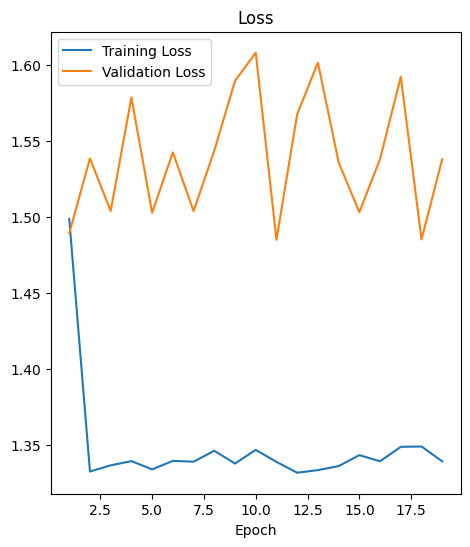

<Figure size 640x480 with 0 Axes>

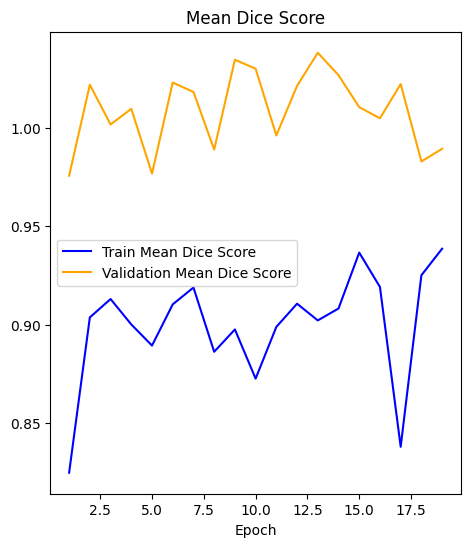

<Figure size 640x480 with 0 Axes>

In [61]:
epoch = range(1, num_epochs)

# Plot Loss Curves
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epoch, train_loss_epoch_values, label='Training Loss')
plt.plot(epoch, val_loss_epoch_values, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.show()

# Plot Dice Coefficient Curves
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 2)
plt.plot(epoch, ds_mean_train_values, 'blue', label = 'Train Mean Dice Score')
plt.plot(epoch, ds_mean_val_values, 'orange', label = 'Validation Mean Dice Score')
plt.title('Mean Dice Score')
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.show()

**4.2 Check best model output**

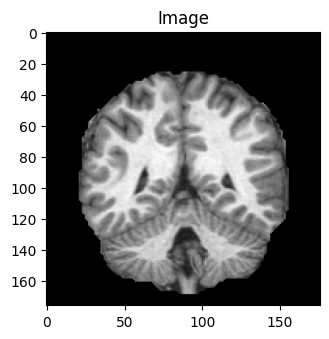

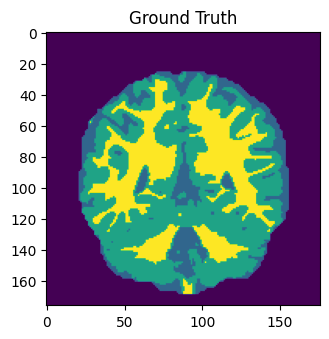

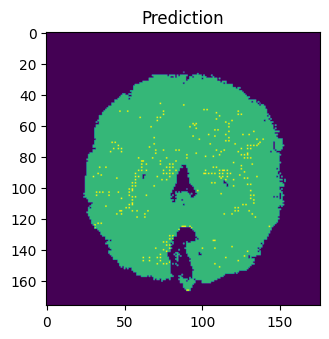

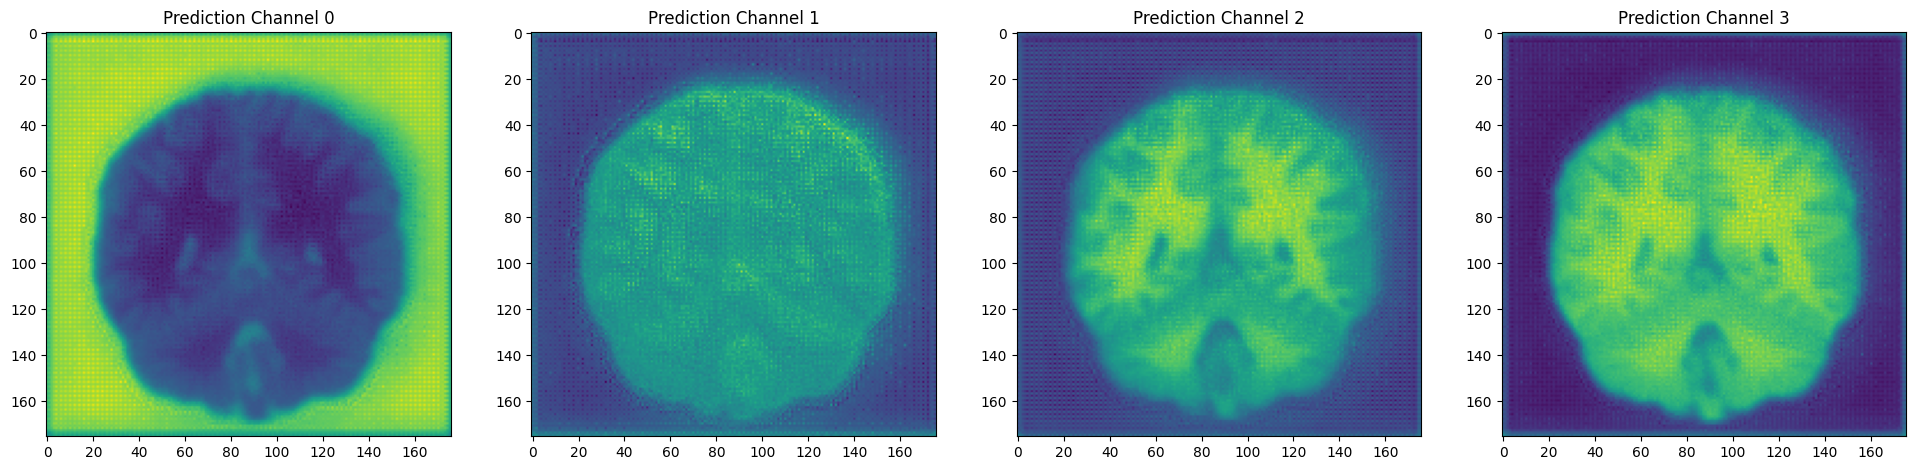

In [62]:
data_dir = root_dir + '/best_model_coronal'
model_coronal.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model_coronal.pth")))
model_coronal.eval()
with torch.no_grad():
    val_input = val_dataset_coronal_subset[8]["image"].unsqueeze(0)
    val_labels = val_dataset_coronal_subset[8]["label"]
    val_outputs = model_coronal(val_input)
    # predictions = torch.argmax(val_outputs, dim = 1)
    predictions = val_outputs

# Plot Image
plt.figure("image", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(val_input[0][0], cmap='gray')
plt.show()

# Plot Ground Truth
plt.figure("label", (12, 6))
plt.subplot(1, 3, 2)
plt.title(f"Ground Truth")
plt.imshow(val_labels[0, :, :])
plt.show()

# Plot Prediction
plt.figure("prediction", (12, 6))
plt.subplot(1, 3, 3)
plt.title(f"Prediction")
plt.imshow(torch.argmax(predictions, dim=1)[0, :, :])
plt.show()

# Visualize the 4 channel prediction corresponding to this image
plt.figure("prediciton", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(f"Prediction Channel {i}")
    plt.imshow(predictions[0, i, :, :])
plt.show()

